In [6]:
from dependencies.units.pressure import Pressure 
from dependencies.units.temperature import Temperature 
from dependencies.units.density import Density 
from dependencies.units.velocity import Velocity 
from dependencies.units.dynamic_viscosity import DynamicViscosity
from dependencies.units.kinematic_viscosity import KinematicViscosity
from dependencies.units.temperature_specific_energy import TemperatureSpecificEnergy
from dependencies.units.length import Length 
from dependencies.units.acceleration import Acceleration


In [ ]:
from dataclasses import dataclass

import pyatmos
import numpy as np
from scipy.optimize import newton

@dataclass
class ThermoState:
    P: Pressure
    T: Temperature
    rho: Density
    Pt: Pressure
    Tt: Temperature
    rhot: Density
    a: Velocity
    M: float
    V: Velocity
    mu: DynamicViscosity
    nu: KinematicViscosity
    beta: float
    gam: float
    cp: TemperatureSpecificEnergy
    R: TemperatureSpecificEnergy
    h: Length
    g: Acceleration

ModuleNotFoundError: No module named 'pyatmos'

In [8]:
from dataclasses import dataclass, field 

@dataclass 
class CEM_state: 
    p_in_comp: float = None
    pi_comp: float = None 
    mdot_in_comp: float = None 
    mdot_out_exp: float = None 
    p_in_exp: float = None 
    pi_exp: float = None 
    P_comp: float = None 
    P_motor_comp = None
    P_exp: float = None
    P_generator_exp: float = None
    P_CEM: float = None 

class CEM: 
    def __init__(self, compressor_efficiency, expander_efficiency, motor_efficiency, generator_efficiency, specific_weight):
        self.compressor_efficiency = compressor_efficiency
        self.expander_efficiency = expander_efficiency 
        self.motor_efficiency = motor_efficiency 
        self.generator_efficiency = generator_efficiency
        self.specific_weight = specific_weight
        self.weight = 0

    def evaluate(self, p_air_FC, thermo_state_in, mdot_air_in, lambda_O2, p_drop_hum, p_drop_fc):
        Tt_in = thermo_state_in.Tt.K 
        Pt_in = thermo_state_in.Pt.bar 
        Cp = 1004
        gam = 1.4
        comp_p_req = mdot_air_in * Cp* Tt_in * (((p_air_FC + p_drop_hum) / Pt_in) ** ((gam - 1) / gam) - 1) / self.compressor_efficiency
        input_p = comp_p_req / self.motor_efficiency 
        p_exp = p_air_FC - p_drop_fc - p_drop_hum
        Tt_exp = Tt_in * (p_exp / Pt_in) ** ((gam - 1) / gam)
        mdot_air_out = mdot_air_in - mdot_air_in / lambda_O2 * 0.233
        exp_p_ext = mdot_air_out * Cp * Tt_exp * (1 - (Pt_in / p_exp) ** ((gam - 1) / gam)) * self.expander_efficiency
        output_p = exp_p_ext * self.generator_efficiency
        p_req = input_p - output_p 
        state = CEM_state()
        state.p_in_comp = Pt_in 
        state.pi_comp = (p_air_FC + p_drop_hum) / Pt_in 
        state.mdot_in_comp = mdot_air_in 
        state.mdot_out_exp = mdot_air_out 
        state.p_in_exp = p_exp 
        state.pi_exp = Pt_in / p_exp 
        state.P_comp = comp_p_req
        state.P_motor_comp = input_p
        state.P_exp = exp_p_ext
        state.P_generator_exp = output_p 
        state.P_CEM = p_req
        return state
    
    def set_weight(self, compressor_max_power):
        self.power_rating = compressor_max_power
        self.weight = compressor_max_power / self.specific_weight / 1000

In [9]:
import math
import matplotlib.pyplot as plt
import numpy as np 
from scipy.optimize import minimize_scalar

class PEMState: 
    """
    Dataclass which stores state variables of a PEM fuel cell 
    """
    net_power: float = None 
    net_heat: float = None 
    P_compressor: float = None 
    current_density: float = None 
    mdot_fuel: float = None 
    efficiency: float = None 

class PEMCell:
    """
    PEM Fuel Cell class

    Constants:
    ----------
    R: float 
        Universal gas constant (J / (mol*K))
    F: float 
        Faraday constant (C / mol)
    E_C: float 
        Activation energy of ORR (J)
    MMH2: float 
        Molar mass of H2 (kg/mol)
    MMO2: float 
        Molar mass of O2 (kg/mol)
    """
    R = 8.314
    F = 96485 
    E_C = 66000
    MMH2 = 2.0 * 10 ** -3 
    MMO2 = 32 * 10 ** -3 
    O2_mass_frac = 0.233

    def __init__(self, 
                 type, 
                 t_m, 
                 a_c,
                 L_c, 
                 A, 
                 CEM, 
                 maximum_deg=0,
                 rated_cd = None,
                 rated_pd = None,
                 rated_p_drop_fc=Pressure(bar=0.240), 
                 rated_p_drop_hum=Pressure(bar=0.025), 
                 gamma_para = 0.03, 
                 alpha=0.375, 
                 gamma = 0.45, 
                 lambda_eff=9.15, 
                 c1 = 0.0435, 
                 c2 = 0.0636, 
                 i0ref = 9 * 10 ** -6, 
                 i0ref_P_ref = Pressure(bar = 1), 
                 i0ref_T_ref = Temperature(K = 353),
                 i_lim_multiplier = 1,
                 area_specific_mass = 2.5):
        """
        Initialize the PEM fuel cell with given parameters.

        Parameters:
        ----------
        type: string
            The type of PEM model to use, "LT" for low temperature, or "HT" for high temperature
        t_m: Length 
            The membrane thickness of the PEM cell 
        a_c: float 
            The catalyst specific area in cm^2 / mg Pt
        L_c: float 
            The catalyst platinum loading in mg Pt / cm^2
        A: Area 
            The membrane area 
        CEM: CEM 
            The compressor expander module of the air supply system 
        maximum_deg: float 
            The maximum voltage drop due to degradation of the fuel cell at EOL
        rated_cd: float 
            The rated current density for pressure drop calculations (typically the current density at max power)
            Can be calculated using the evaluate_max_PD method
            Defaults to None 
        rated_pd: float 
            The rated power density of the fuel cell 
            Defaults to None 
        rated_p_drop_fc: Pressure 
            The pressure drop at rated current density of the fuel cell cathode 
            Defaults to 0.240 bar 
        rated_p_drop_hum: Pressure 
            The pressure drop at rated current density of one side of the membrane humidifier
            Defaults to 0.025 bar
        gamma_para: float 
            The parasitic power draw divided by the gross cell power 
            Does not include compressor/ram-air heat exchanger coolant power
            Defaults to 0.03
        alpha: float 
            The charge transfer coefficient
            Used for both models, is between 0-1, but usually around 0.5 
            Defaults to 0.375 (matches reports and experimental data)
        gamma: float 
            The activation loss pressure dependency coefficient
            Generally 1 for HT-PEM 
            Defaults to 0.45 for LT-PEM
        lambda_eff: float 
            Fitting parameter used to calculate the conductivity of Nafion membranes 
            Only used if type is "LT"
            Values from 9-24 are reasonable 
            Defaults to 9.15 for fully humidifed air 
        c1: float 
            Membrane conductivity of HT PBI membrane at 100 C (ms/cm)
            Only used if type is "HT"
            defaults to 0.0435 for standard PBI membrane 
        c2: float 
            Membrane conductivity of HT PBI membrane at 200 C (ms/cm)
            Only used if type is "HT"
            defaults to 0.0636 for standard PBI membrane 
        i0ref: float 
            Reference current density for activation losses for HT PEM model (A / cm^2 Pt)
            Note that it is given per unit catalyst surface area, not per membrane area 
            defaults to 4e-8
        i0ref_P_ref: float 
            Pressure at which i0ref was determined  
            defaults to 1 bar 
        ioref_T_ref: float 
            Temperature at which i0ref was determined 
            defaults to 369.05 K
        i_lim_multiplier: float 
            The value which the limiting current is multiplied by for advanced PEM systems
        area_specific_mass: float 
            The mass per active membrane area of the fuel cell (kg/m2)
        """
        if type == "LT": 
            self.calculate_ohmic_losses = self.calculate_ohmic_losses_LT
            self.calculate_limiting_current_density = self.calculate_limiting_current_density_LT
            self.calculate_concentration_losses = self.calculate_concentration_losses_LT
        elif type == "HT": 
            self.calculate_ohmic_losses = self.calculate_ohmic_losses_HT
            self.calculate_limiting_current_density = self.calculate_limiting_current_density_HT
            self.calculate_concentration_losses = self.calculate_concentration_losses_HT
        else: 
            raise ValueError('PEM type not supported, currently supported types are "LT" and "HT"')
        self.type = type 
        self.t_m = t_m.cm
        self.alpha = alpha
        self.a_c = a_c
        self.L_c = L_c
        self.A = A.cm2
        self.gamma = gamma
        self.lambda_eff = lambda_eff
        self.c1 = c1 
        self.c2 = c2
        self.CEM = CEM
        self.maximum_deg = maximum_deg
        self.rated_cd = rated_cd
        self.rated_pd = rated_pd
        self.rated_p_drop_fc = rated_p_drop_fc.bar
        self.rated_p_drop_hum = rated_p_drop_hum.bar
        self.gamma_para = gamma_para
        self.i0ref = i0ref 
        self.i0ref_P_ref = i0ref_P_ref.bar 
        self.i0ref_T_ref = i0ref_T_ref.K
        self.i_lim_multiplier = i_lim_multiplier
        self.area_specific_mass = area_specific_mass

    def set_rated_cd(self, rated_cd, rated_pd): 
        """
        Sets the rated cd and pd of the fuel cell system 

        Parameters: 
        ----------
        rated_CD: float
            The current density (A/cm2) to set 
        rated_pd: float 
            The power density (W/cm2) to set 
        """
        self.rated_cd = rated_cd 
        self.rated_pd = rated_pd

    def calculate_P_drop_hum(self, i):
        """
        Calculates the pressure drop across the humidifier for the rated current 

        Parameters: 
        ----------
        i: float 
            Current Density (Acm2) to calculate the pressure drop 

        Returns: 
        ----------
        float 
            The Humidifier pressure drop in bar
        """
        P_drop = (i/self.rated_cd) ** 2 * self.rated_p_drop_hum
        return P_drop

    def calculate_P_drop_stack(self, i):
        """
        Calculates the pressure drop across the stack for the rated current 

        Parameters: 
        ----------
        i: float 
            Current Density (Acm2) to calculate the pressure drop

        Returns:
        ---------- 
        float 
            The stack pressure drop in bar 
        """
        P_drop = (i/self.rated_cd) ** 2 * self.rated_p_drop_fc
        return P_drop

    def calculate_P_O2(self, P_air, T_fc, RH, lambda_O2, P_drop, i): 
        """
        Calculate the partial pressure of oxygen at the fuel cell cathode 

        Parameters: 
        ----------
        P_air: float 
            The input air pressure to the fuel cell (bar)
        T_fc: float 
            The fuel cell stack temperature (K)
        RH: float 
            The relative humidity of the oxygen stream (0-1)
        lambda_O2: float 
            The oxygen excess ratio (above stoichometric)
        P_drop: float 
            The pressure drop (bar) across the fuel cell cathode 
        i: float 
            The current density (Acm2) to calculate the partial pressure at

        Returns: 
        ----------
        float
            The oxygen partial pressure (bar)
        """
        T_C = T_fc - 273.15
        log_P_H2O = -2.1794 + 0.02953 * T_C - 9.1837e-5 * T_C**2 + 1.4454e-7 * T_C**3
        P_H2O = 10 ** log_P_H2O
        N = 0.291 * i / (T_fc ** 0.832)
        P_O2 = 0.21 * (P_air - P_drop / 2 - RH * P_H2O) *  ((1 + (lambda_O2 - 1) / lambda_O2) / 2)/ math.exp(N)
        return P_O2
    
    def calculate_P_H2(self, P_H2_input, T_fc, RH, i):
        """
        Calculate the partial pressure of hydroen at the fuel cell anode

        Parameters: 
        ----------
        P_H2_input: float 
            The input hydrogen pressure to the fuel cell (bar)
        T_fc: float 
            The fuel cell stack temperature (K)
        RH: float 
            The relative humidity of the oxygen stream (0-1)
        i: float 
            The current density (Acm2) to calculate the partial pressure at

        Returns: 
        ----------
        float
            The hydrogen partial pressure (bar)
        """
        T_C = T_fc - 273.15
        log_P_H2O = -2.1794 + 0.02953 * T_C - 9.1837e-5 * T_C**2 + 1.4454e-7 * T_C**3
        P_H2O = 10 ** log_P_H2O
        P_H2 = 0.5 * (P_H2_input / math.exp(1.653 * i / T_fc**1.334) - RH * P_H2O)
        return P_H2

    def calculate_E_cell(self, T_fc, P_H2, P_O2):
        """
        Calculates the reversible Nernst Voltage of the cell

        Parameters:
        ----------
        T_fc: float 
            The fuel cell stack temperature (K)
        P_H2: float 
            The hydrogen partial pressure (bar)
        P_O2: float 
            The oxygen partial pressure (bar)

        Returns:
        ----------
        float 
            The reversible cell potential (V)
        """
        try:
            E_cell = 1.229 - 8.45e-4 * (T_fc - 298.15) + \
            PEMCell.R*T_fc / (4 * self.alpha * PEMCell.F) * (math.log(P_H2) + 0.5 * math.log(P_O2))
        except: 
            return -10
        return E_cell
    
    def calculate_activation_losses(self, T_fc, P_O2, i):
        """
        calculation of activation losses for both high temperature and low temperature fuel cells

        Parameters: 
        ----------
        T_fc: float 
            Stack Temperature (K)
        P_O2: float 
            Oxygen Partial Pressure (bar)
        i: float 
            Current density to evaluate activation losses (A/cm2)
        
        Returns: 
        ----------
        float: 
            Activation voltage loss (V)
        """
        A_const = PEMCell.R * T_fc / (2 * self.alpha * PEMCell.F)
        i0 = self.i0ref * self.L_c * self.a_c * (P_O2/self.i0ref_P_ref) ** (self.gamma) * \
            math.exp(-PEMCell.E_C / (PEMCell.R * T_fc) * (1 - (T_fc / self.i0ref_T_ref)))
        eta_act = A_const * math.log(i/i0)
        return eta_act
    
    def calculate_ohmic_losses_LT(self, T_fc, i):
        """
        Calculation of ohmic losses for low temperature fuel cells

        Parameters: 
        ----------
        T_fc: float 
            Stack Temperature (K)
        i: float 
            Current density to evaluate activation losses (A/cm2)
        
        Returns: 
        ----------
        float: 
            Ohmic voltage loss (V)
        """
        t_m = self.t_m 
        lambda_eff = self.lambda_eff
        num = 181.6 * (1 + 0.03 * i + 0.062 * (T_fc/303) ** 2 * i ** 2.5)
        denom = (lambda_eff - 0.634 - 3 * i) * math.exp(4.18 * (T_fc - 303) / T_fc)
        rho = num/denom 
        eta_ohmic = (rho * t_m) * i
        return eta_ohmic 
    
    def calculate_ohmic_losses_HT(self, T_fc, i):
        """
        Calculation of ohmic losses for high temperature fuel cells

        Parameters: 
        ----------
        T_fc: float 
            Stack Temperature (K)
        i: float 
            Current density to evaluate activation losses (A/cm2)
        
        Returns: 
        ----------
        float: 
            Ohmic voltage loss (V)
        """
        t_m = self.t_m 
        c1 = self.c1
        c2 = self.c2
        s = (T_fc - 373.15) / (100) * (c2 - c1) + c1
        rho = 1/s 
        eta_ohmic = (rho * t_m) * i
        return eta_ohmic

    def calculate_concentration_losses_LT(self, T_fc, P_O2, RH, lambda_O2, P_drop, i):
        """
        Calculation of concentration losses for low temperature fuel cells 

        Parameters:
        ----------
        T_fc: float 
            Stack Temperature (K)
        P_O2: float 
            Oxygen partial pressure (bar)
        RH: float 
            Relative humidity of the oxygen stream (0-1)
        lambda_O2: float 
            Oxygen excess ratio (above stoichometric)
        P_drop: float 
            Pressure drop across the fuel cell stack (bar)
        i: float 
            Current density to evaluate activation losses (A/cm2)
        
        Returns:
        ----------
        float: 
            Concentration voltage loss (V)
        """
        i_lim = self.calculate_limiting_current_density_LT(T_fc, P_O2, RH, lambda_O2, P_drop, i)
        if i >= i_lim: 
            return 10
        else: 
            eta_conc = (1 + 1 / self.alpha) * PEMCell.R * T_fc / (2 * PEMCell.F) * math.log(i_lim / (i_lim - i)) 
            return eta_conc
        
    def calculate_limiting_current_density_LT(self, T_fc, P_O2, RH, lambda_O2, P_drop, i, **kwargs): 
        """
        Calculation of the limiting current density for LT-PEM

        Parameters:
        ----------
        T_fc: float 
            Stack Temperature (K)
        P_O2: float 
            Oxygen partial pressure (bar)
        RH: float 
            Relative humidity of the oxygen stream (0-1)
        lambda_O2: float 
            Oxygen excess ratio (above stoichometric)
        P_drop: float 
            Pressure drop across the fuel cell stack (bar)
        i: float 
            Current density to evaluate activation losses (A/cm2)
        
        Returns:
        -----------
        float: 
            limiting current density (A/cm^2)
        """
        P_O2_ref_1_atm = self.calculate_P_O2(1, T_fc, RH, lambda_O2, P_drop, i)
        P_O2_ref_2_5_atm = self.calculate_P_O2(2.5, T_fc, RH, lambda_O2, P_drop, i)
        i_lim = (2.25 - 1.65) * (P_O2 - P_O2_ref_1_atm)**1 / (P_O2_ref_2_5_atm-P_O2_ref_1_atm)**1 + 1.65
        return self.i_lim_multiplier * i_lim
        
    def calculate_concentration_losses_HT(self, T_fc, P_O2, RH, lambda_O2, P_drop, i):
        """
        Calculation of concentration losses for high temperature fuel cells 

        Parameters:
        ----------
        T_fc: float 
            Stack Temperature (K)
        P_O2: float 
            Oxygen partial pressure (bar)
        RH: float 
            Relative humidity of the oxygen stream (0-1)
        lambda_O2: float 
            Oxygen excess ratio (above stoichometric)
        P_drop: float 
            Pressure drop across the fuel cell stack (bar)
        i: float 
            Current density to evaluate activation losses (A/cm2)
        
        Returns:
        -----------
        float: 
            Concentration voltage loss (V)
        """
        i_lim = self.calculate_limiting_current_density_HT(T_fc, P_O2, RH, lambda_O2, P_drop, i)
        if i >= i_lim: 
            return 10
        else: 
            eta_conc = (1 + 1.8/self.alpha) * PEMCell.R * T_fc / (2* PEMCell.F) * math.log(i_lim / (i_lim - i)) 
            return eta_conc

    def calculate_limiting_current_density_HT(self, T_fc, P_O2, RH, lambda_O2, P_drop, i): 
        """
        Calculation of the limiting current density for HT-PEM

        Parameters:
        ----------
        T_fc: float 
            Stack Temperature (K)
        P_O2: float 
            Oxygen partial pressure (bar)
        RH: float 
            Relative humidity of the oxygen stream (0-1)
        lambda_O2: float 
            Oxygen excess ratio (above stoichometric)
        P_drop: float 
            Pressure drop across the fuel cell stack (bar)
        i: float 
            Current density to evaluate activation losses (A/cm2)
        
        Returns:
        -----------
        float: 
            limiting current density (A/cm^2)
        """
        P_O2_ref_1_atm = self.calculate_P_O2(1, T_fc, RH, lambda_O2, P_drop, i)
        P_O2_ref_2_atm = self.calculate_P_O2(2, T_fc, RH, lambda_O2, P_drop, i)
        i_lim = (2.15 - 1.4) * (P_O2 - P_O2_ref_1_atm)**1 / (P_O2_ref_2_atm-P_O2_ref_1_atm)**1 + 1.4
        return self.i_lim_multiplier * i_lim
    
    def calculate_voltage(self, i, T_fc, P_H2_input, P_air, RH, lambda_O2, p_drop_fc, degradation=0):
        """
        Calculates the output voltage of the fuel cell by subtracting the activation,
        ohmic, and concentration voltage losses from the reversible Nernst voltage, E_cell.

        Parameters:
        ----------
        i: float 
            The current density to evaluate the cell voltage at (A/cm^2)
        T_fc: float 
            Temperature of the fuel cell (K)
        P_H2_input: float 
            Pressure of the hydrogen stream (bar)
        P_air: float 
            Pressure of the incoming air (bar)
        RH: float 
            Relative humidity of the air and hydrogen streams (0-1)
        lambda_O2: float 
            Air excess ratio (above stoichometric)
        p_drop_fc: float 
            Pressure drop of the fuel cell at the rated current density (bar)
        degradation: float 
            The percent of maximumm degradation to evaluate divided by 100
            optional, defaults to 0 (0% of self.maximum_deg)

        Returns:
        ----------
        float: 
            Output voltage of the fuel cell (V)
        """
        P_O2 = self.calculate_P_O2(P_air, T_fc, RH, lambda_O2, p_drop_fc, i)
        P_H2 = self.calculate_P_H2(P_H2_input, T_fc, RH, i)
        E_cell = self.calculate_E_cell(T_fc, P_H2, P_O2)
        eta_act = self.calculate_activation_losses(T_fc, P_O2, i)
        eta_ohmic = self.calculate_ohmic_losses(T_fc, i)
        eta_conc = self.calculate_concentration_losses(T_fc, P_O2, RH, lambda_O2, p_drop_fc, i)

        # Calculate the output voltage of the fuel cell
        V_cell = E_cell - eta_act - eta_ohmic - eta_conc - degradation * self.maximum_deg
        V_loss = eta_act + eta_ohmic + eta_conc + degradation * self.maximum_deg
        return V_cell, V_loss
    
    def evaluate_max_gross_power(self, T_fc, p_H2, FC_air_p, RH, lambda_O2, degradation=0, **kwargs):
        
        P_O2 = self.calculate_P_O2(FC_air_p, T_fc, RH, lambda_O2, self.rated_p_drop_fc, 0)
        i_lim = self.calculate_limiting_current_density(T_fc, P_O2, RH, lambda_O2, 0, i=0)

        def evaluate_power(i): 
            V_cell, V_loss = self.calculate_voltage(i, T_fc, p_H2, FC_air_p, RH, lambda_O2, self.rated_p_drop_fc, degradation)
            PD = -V_cell * i 
            return PD

        res = minimize_scalar(evaluate_power, bounds = (0.2 * i_lim, 0.95 * i_lim))
        rated_cd = res.x 
        rated_pd = -res.fun 
        return rated_cd, rated_pd
    
    def evaluate_max_net_power(self, T_fc, p_H2, FC_air_p, RH, lambda_O2, thermo_state, degradation=0): 
        P_O2 = self.calculate_P_O2(FC_air_p, T_fc, RH, lambda_O2, self.rated_p_drop_fc, 0)
        i_lim = self.calculate_limiting_current_density(T_fc, P_O2, RH, lambda_O2, 0, i=0)
        compressor_powers = []
        def evaluate_power(i): 
            res = self.evaluate(i, T_fc, p_H2, FC_air_p, RH, lambda_O2, thermo_state, degradation)
            net_power = res[1]
            compressor_powers.append(res[4])
            return -net_power
        
        res = minimize_scalar(evaluate_power, bounds = (0.2 * i_lim, 0.95 * i_lim))
        compressor_power = compressor_powers[-1]
        rated_cd = res.x 
        rated_power = -res.fun 
        return rated_cd, rated_power, compressor_power

    def evaluate_CEM(self, FC_air_p, thermo_state_in, mdot_air_in, lambda_O2, p_drop_hum, p_drop_fc):
        """
        Evaluates the power required by the CEM (compressor-expander module)

        Parameters: 
        ----------
        FC_air_p: float 
            Air pressure after the humidifier entering the fuel cell (bar)
        thermo_state_in: ThermoState 
            Air thermostate entering the compressor
        mdot_air_in: float 
            Mass flow of air entering the fuel cell and compressor (kg/s)
        lambda_O2: float 
            Oxygen excess ratio (above stoichometric)
        p_drop_hum: float 
            The pressure drop (bar) through the humidifier 
        p_drop_fc: float 
            The pressure drop (bar) through the fuel cell

        Returns: 
        ----------
        float: 
            The power required to run the CEM at the given operating conditions (W)
        """
        p_air_out = FC_air_p + p_drop_hum 
        state = self.CEM.evaluate(p_air_out, thermo_state_in, mdot_air_in, lambda_O2, p_drop_hum, p_drop_fc)
        power_req = state.P_CEM
        mdot_out = state.mdot_out_exp
        expander_power = state.P_exp
        return power_req, mdot_out, expander_power
    
    def evaluate(self, i, T_fc, P_H2_input, FC_air_p, RH, lambda_O2, thermo_state_in, degradation=0):
        """
        Determines the fuel cell state of the PEM fuel cell 

        Parameters: 
        ----------
        i: float 
            The current density to evaluate the cell voltage at (A/cm^2)
        T_fc: Temperature 
            Temperature of the fuel cell
        P_H2_input: Pressure
            Pressure of the hydrogen stream 
        FC_air_p: Pressure
            Pressure of the hydrogen air entering the fuel cell
        RH: float 
            Relative humidity of the air and hydrogen streams (0-1)
        lambda_O2: float 
            Air excess ratio (above stoichometric)
        thermo_state_in: ThermoState 
            Conditions of air entering the compressor
        degradation: float 
            The voltage drop due to degradation (V)
            optional, defaults to 0 V 

        Returns: 
        ----------
        float: 
            Hydrogen Mass flow (kg/s)
        float: 
            Net Power (W)
        float: 
            Gross power (W)
        float: 
            Gross heat (W)
        float: 
            Compressor Power (W)
        float: 
            mdot_air_in (kg/s)
        """
        p_drop_fc = self.calculate_P_drop_stack(i)
        if self.type == "LT":
            p_drop_hum = self.calculate_P_drop_hum(i) 
        else: 
            p_drop_hum = 0
        mdot_air_in = i * self.A * PEMCell.MMO2 / (4 * PEMCell.F * PEMCell.O2_mass_frac) * lambda_O2
        mdot_H2 = i * self.A / (2 * PEMCell.F) * PEMCell.MMH2
        V, V_loss = self.calculate_voltage(i, T_fc, P_H2_input, FC_air_p, RH, lambda_O2, p_drop_fc, degradation)
        gross_power = V * i * self.A
        gross_heat = V_loss * i * self.A
        compressor_power, mdot_air_out, expander_power = self.evaluate_CEM(FC_air_p, thermo_state_in, mdot_air_in, lambda_O2, p_drop_hum, p_drop_fc)
        parasitic_power = self.gamma_para * gross_power
        net_power = gross_power - compressor_power - parasitic_power
        return mdot_H2, net_power, gross_power, gross_heat, compressor_power, mdot_air_in, mdot_air_out, expander_power

    def get_weight_estimate(self):
        return self.A / 100 / 100 * self.area_specific_mass 

    def generate_gross_polarization_curve_data(self, T_fc, p_H2, FC_air_p, RH, lambda_O2, CD_end, thermo_state, degradation=0, no_points = 200):
        """
        Generates lists containing the output gross voltage as a function of current density of the fuel cell.

        Parameters:
        ----------
        T_fc: float
            Fuel cell stack temperature (K)
        P_H2_input: float 
            Input partial pressure of hydrogen (bar)
        P_air: float 
            Input partial pressure of air (bar)
        RH: float 
            Relative humidity (0 to 1)
        lambda_O2: float
            Air excess ratio (above stoichometric)
        CD_end: float 
            Current Density to end evaluation at 
        no_points: float 
            Number of current densities to evaluate

        Returns: 
        -----------
        list: 
            current densities that the fuel cell was evaluated at 
        list: 
            output voltages of the fuel cell
        """
        current_densities = np.linspace(0.01, CD_end, no_points)  # Current densities from 0 to 2 A/cm^2 in steps of 0.01 A/cm^2
        voltages = []
        for i in current_densities: 
            p_drop_fc = self.calculate_P_drop_stack(i)
            v = self.calculate_voltage(i, T_fc, p_H2, FC_air_p, RH, lambda_O2, p_drop_fc, degradation)[0]
            if v>0: 
                voltages.append(v)
            else: 
                voltages.append(np.nan)
        return current_densities, np.array(voltages)

    def generate_net_polarization_curve_data(self, T_fc, p_H2, FC_air_p, RH, lambda_O2, CD_end, thermo_state, degradation=0, no_points = 200):
        """
        Generates lists containing the output net voltage as a function of current density of the fuel cell.

        Parameters:
        ----------
        T_fc: float
            Fuel cell stack temperature (K)
        P_H2_input: float 
            Input partial pressure of hydrogen (bar)
        P_air: float 
            Input partial pressure of air (bar)
        RH: float 
            Relative humidity (0 to 1)
        lambda_O2: float
            Air excess ratio (above stoichometric)
        CD_end: float 
            Current Density to end evaluation at 
        no_points: float 
            Number of current densities to evaluate

        Returns: 
        -----------
        list: 
            current densities that the fuel cell was evaluated at 
        list: 
            output voltages of the fuel cell
        """
        current_densities = np.linspace(0.01, CD_end, no_points)  # Current densities from 0 to 2 A/cm^2 in steps of 0.01 A/cm^2
        voltages = []
        for i in current_densities: 
            v = self.evaluate(i, T_fc, p_H2, FC_air_p, RH, lambda_O2, thermo_state, degradation)[1] / i / self.A
            if v>0: 
                voltages.append(v)
            else: 
                voltages.append(np.nan)
        return current_densities, np.array(voltages)

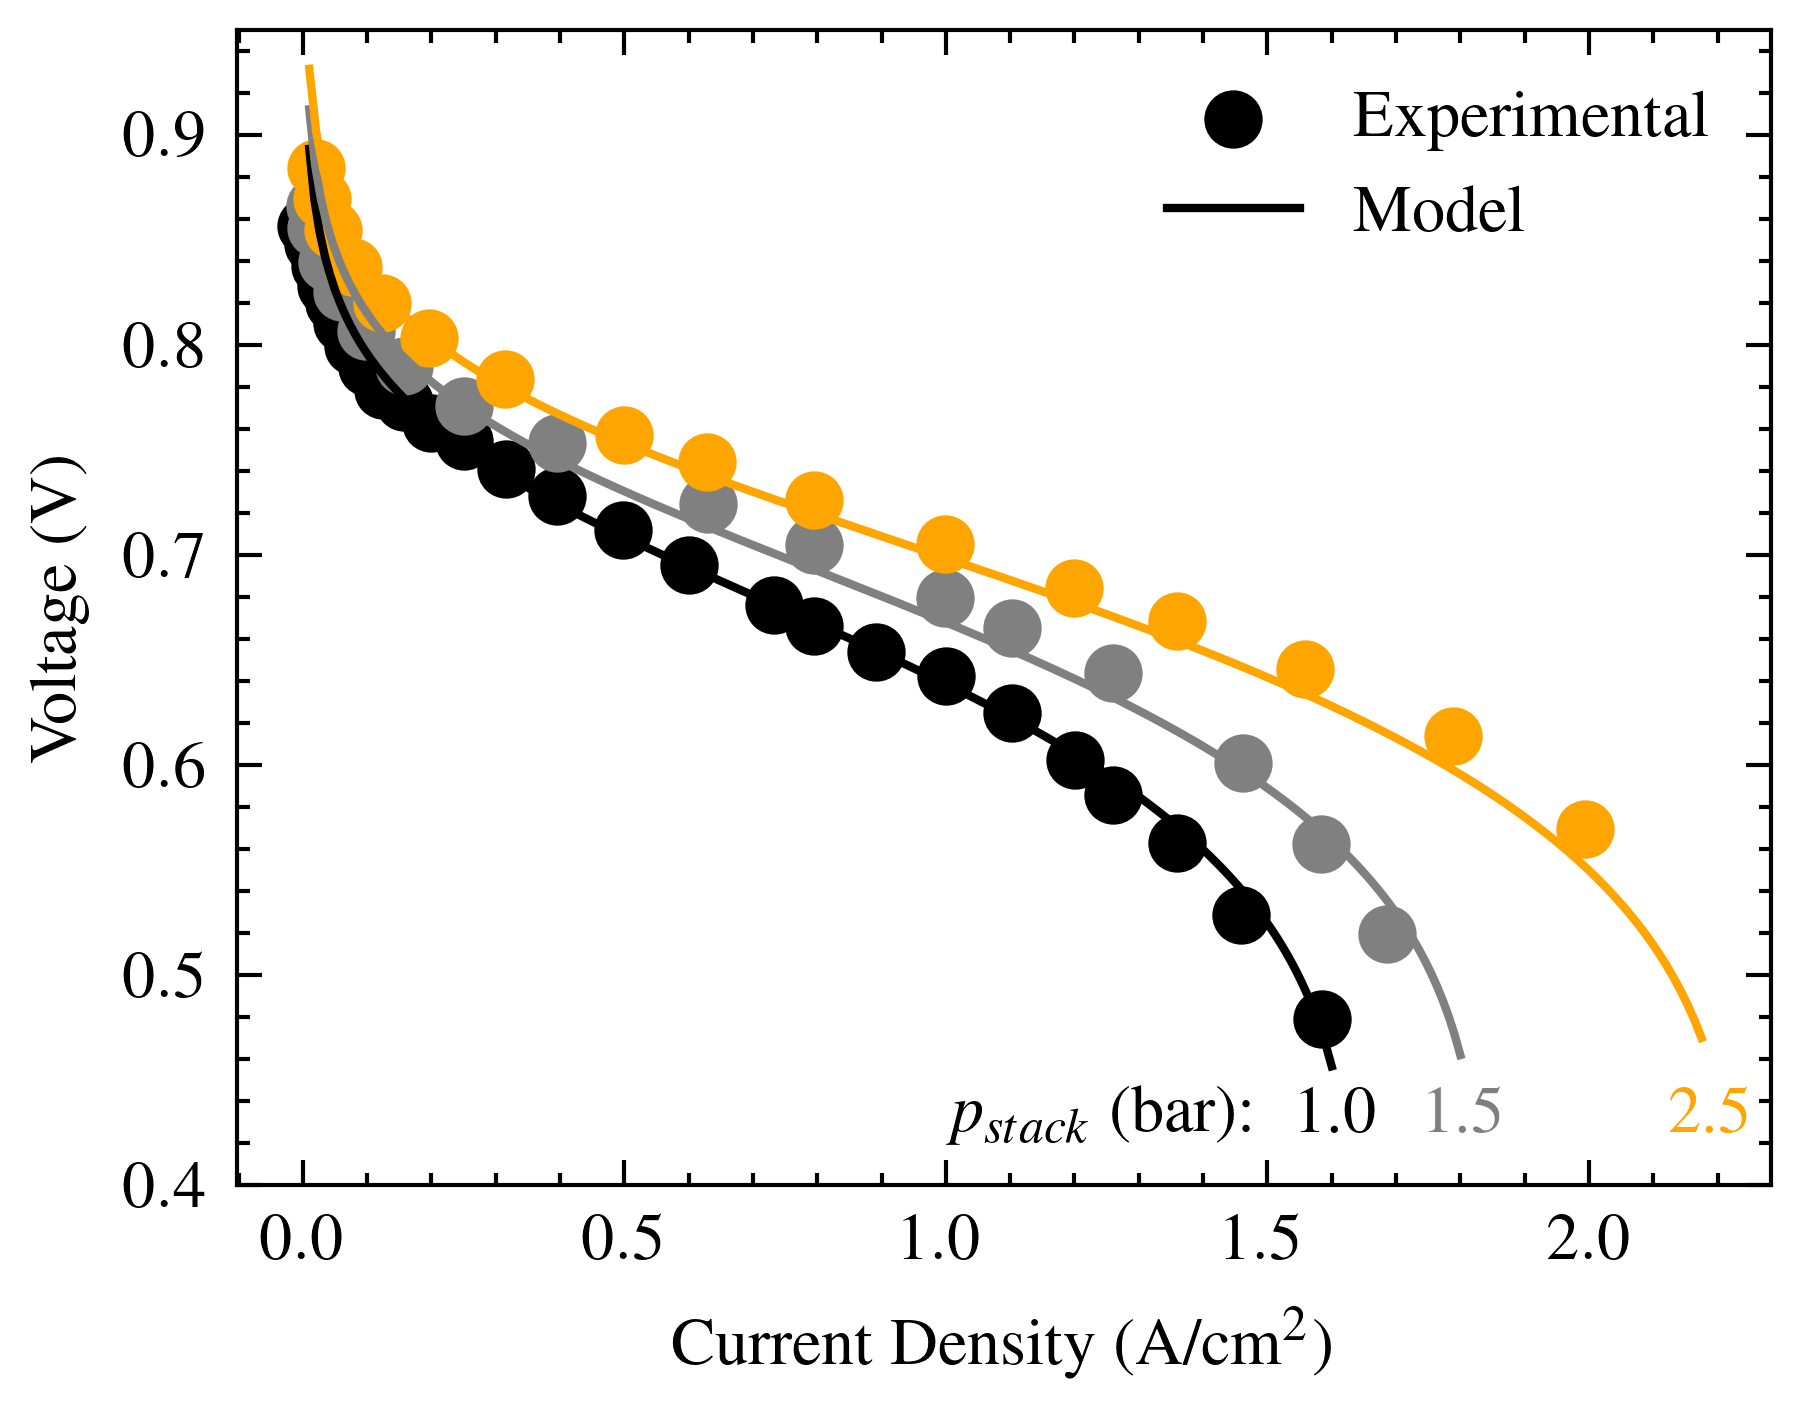

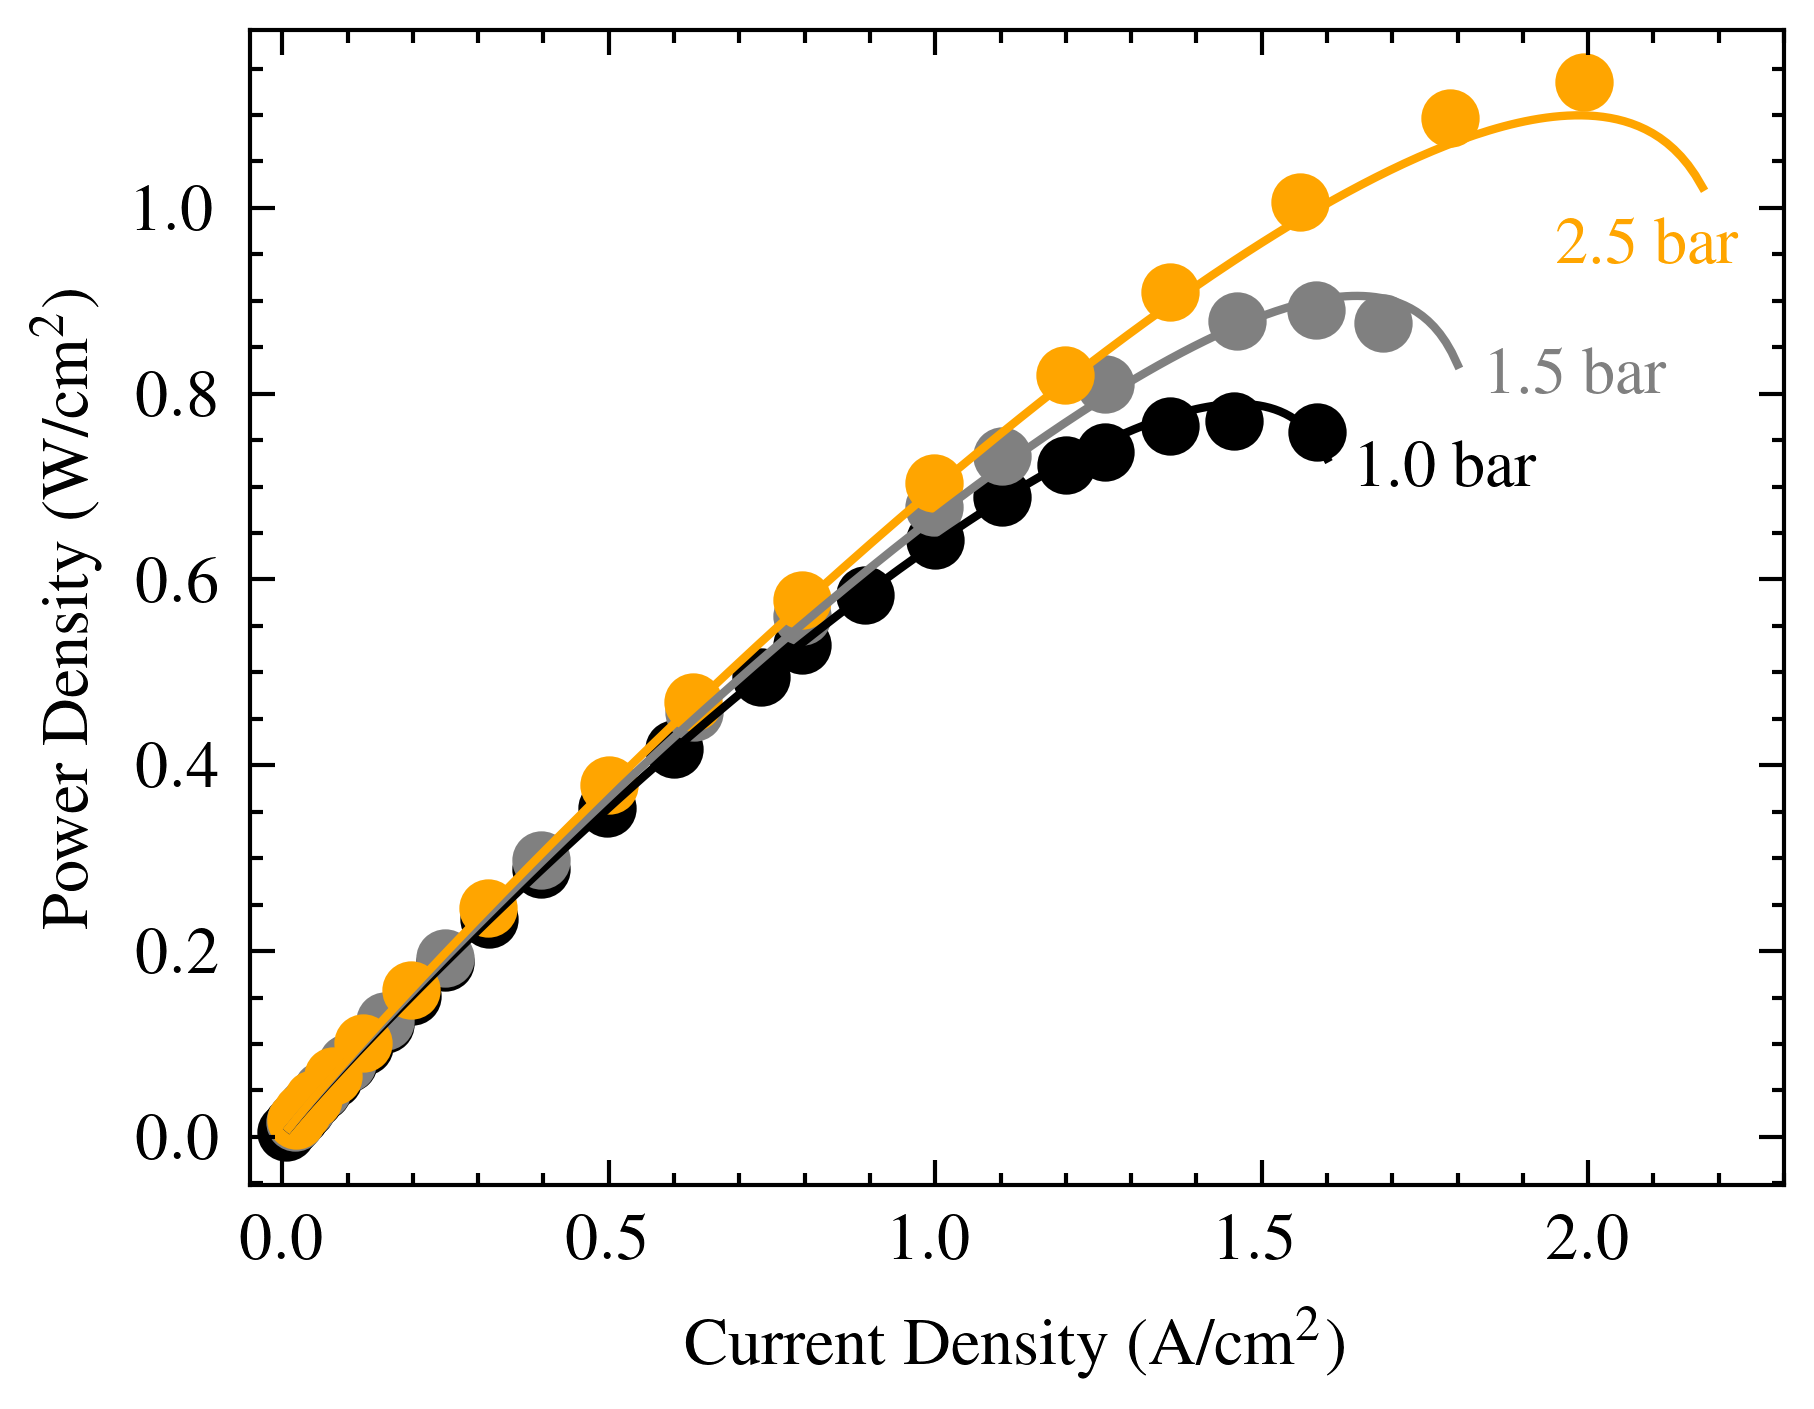

[np.float64(8.623678485158313), np.float64(10.521949924466), np.float64(1.5826129415737071)]
[np.float64(47.75194308222975), np.float64(57.07548763227961), np.float64(7.611279921081469)]
[np.float64(47.75194308222975), np.float64(57.07548763227961), np.float64(7.611279921081469)]
[np.float64(38.75806505733134), np.float64(41.01976608284186), np.float64(1.0311080430252662)]


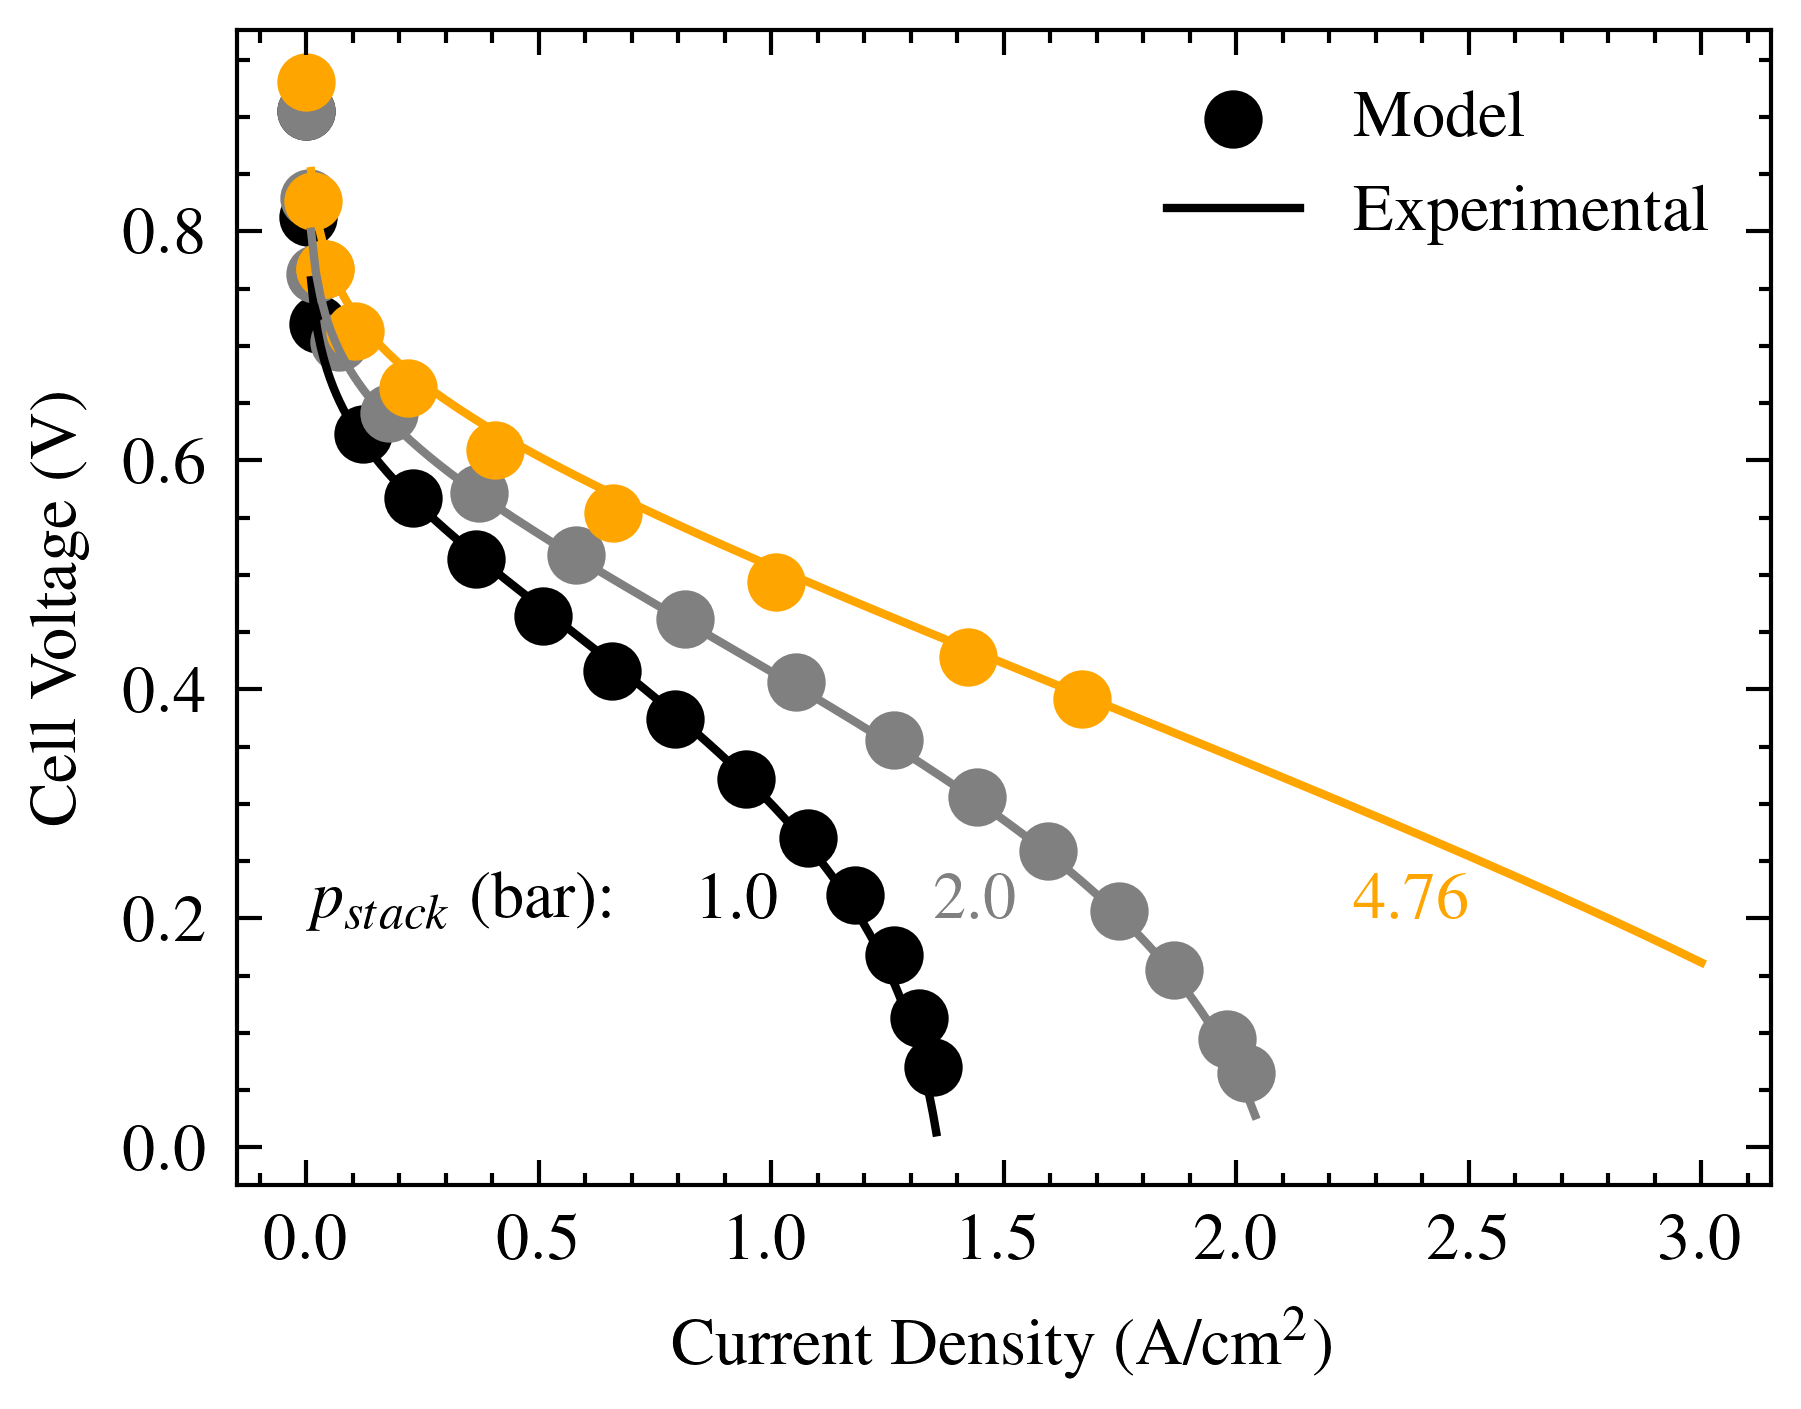

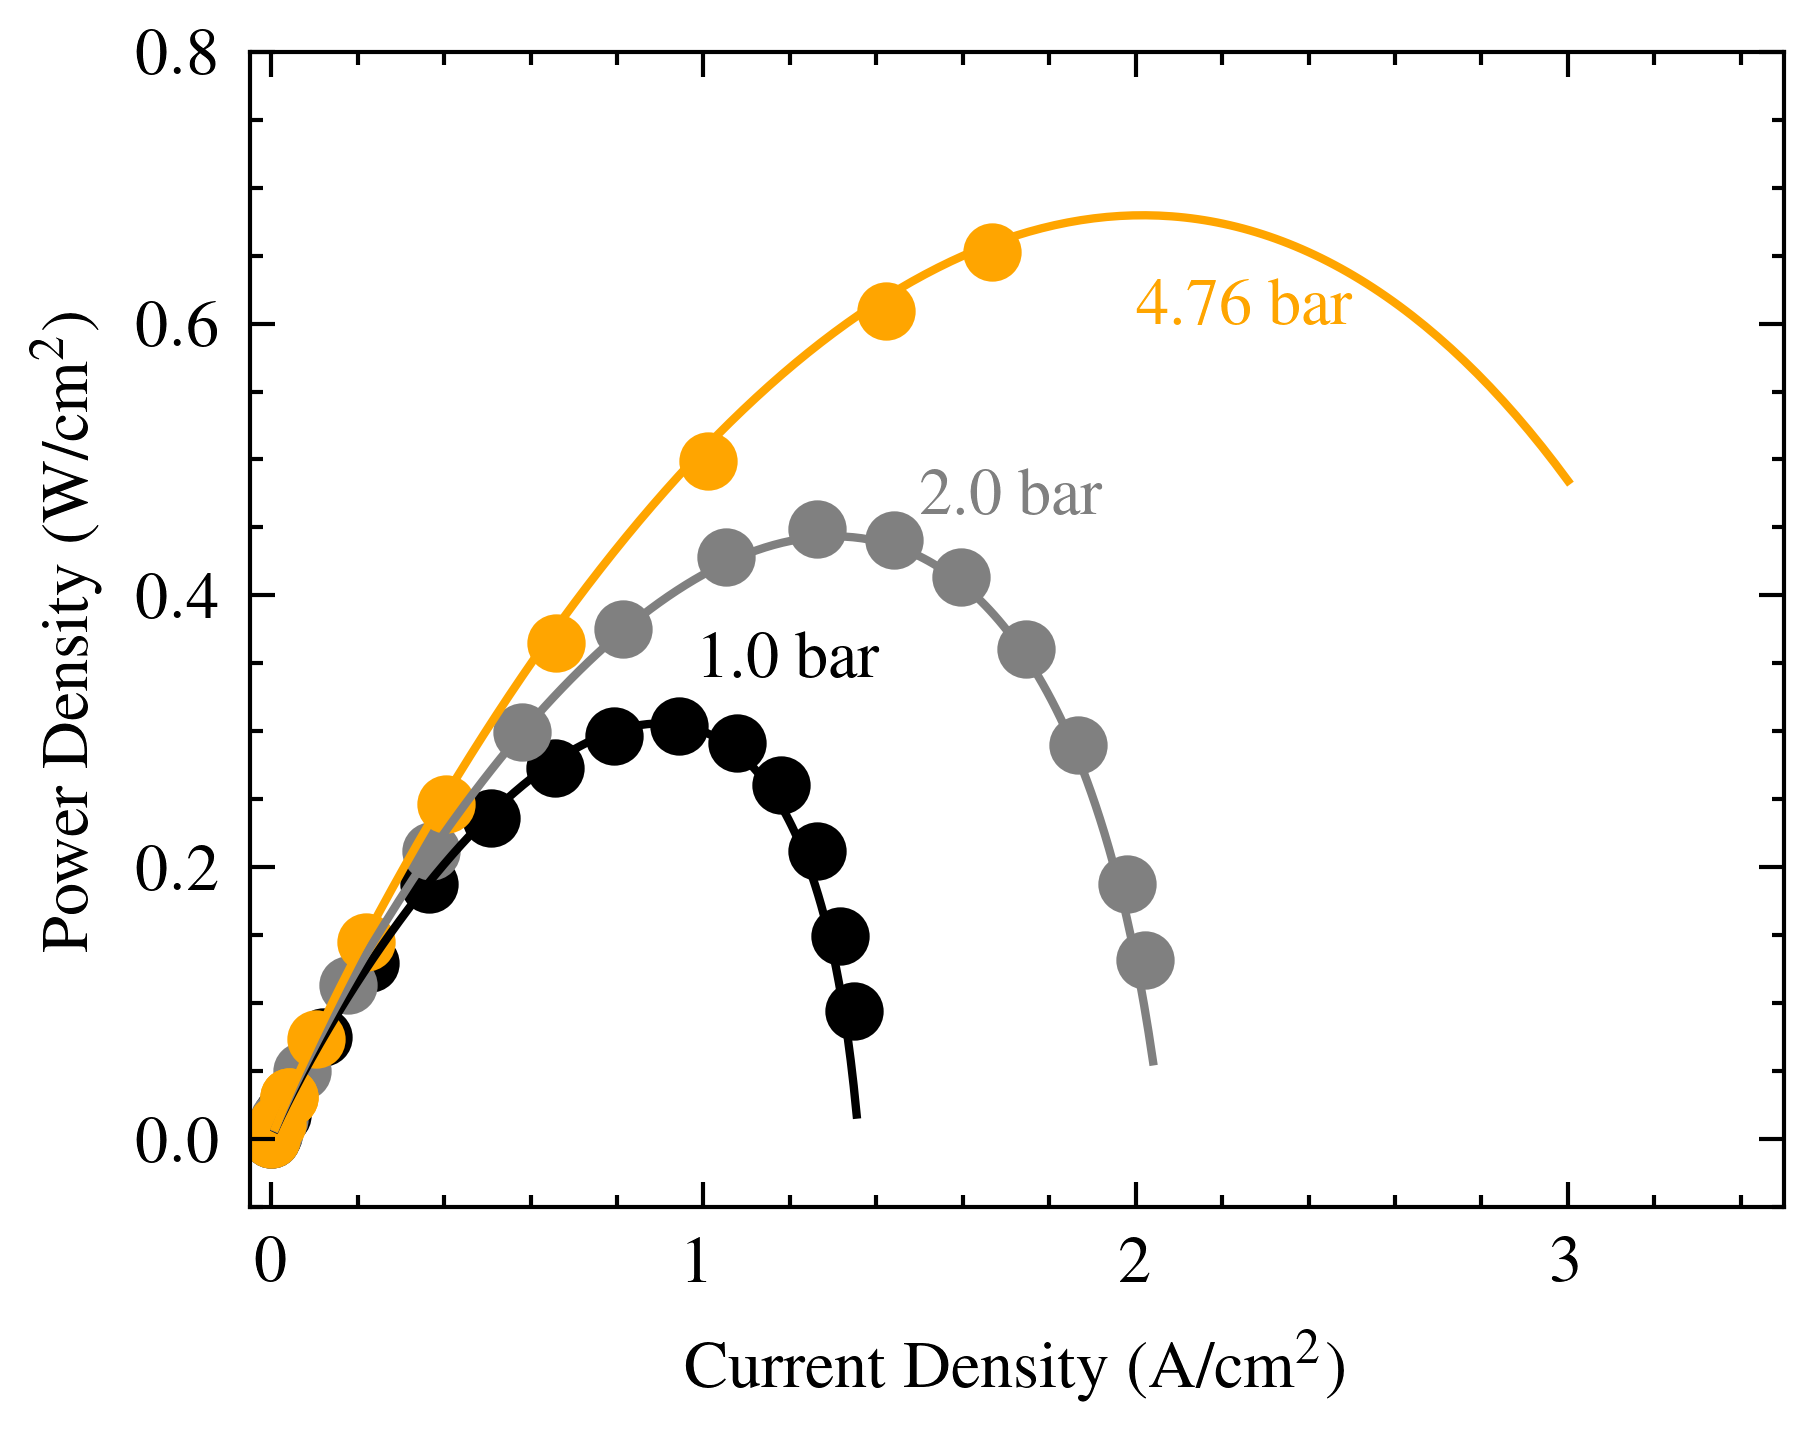

In [25]:
#from src.data.FC.pressure_dependence import CDs_3_5, CDs_1, CDs_2, Vs_1, Vs_2, Vs_3_5, CDs_1_P, CDs_2_P, CDs_3_5_P, Ps_1, Ps_2, Ps_3_5, CDS_HT_LP, CDs_HT_HP, Ps_HT_HP, Ps_HT_LP
from dependencies.data.FC.pressure_dependence import CDs_1, CDs_1_5, CDs_2_5, Vs_1, Vs_1_5, Vs_2_5
from dependencies.data.FC.HT_data import V_P1, V_O2, V_P0, i_O2, i_P0, i_P1
from dependencies.units.area import Area

import matplotlib.pyplot as plt 
import numpy as np 
import scienceplots
import os 

PLOT_DIR = "plots"

thermo_state = ThermoState(
        P=Pressure(atm=1), 
        T=Temperature(C=25), 
        rho=Density(kgm3=1.225), 
        Tt=Temperature(C=25),
        Pt=Pressure(atm=1),
        rhot=Density(kgm3=1.225),
        a=Velocity(ms=343),
        M=0,
        V=Velocity(ms=0),
        mu=None, 
        nu=None, 
        beta=None, 
        gam=1.4,
        cp=TemperatureSpecificEnergy(JkgK=1005),
        R=TemperatureSpecificEnergy(JkgK=287),
        h=Length(m=0),
        g=Acceleration(ms2=9.81)
    )

t_m = Length(cm=0.0024)  # Membrane thickness in cm
t_m2 = Length(cm=0.005)
t_m_wang= Length(cm=0.0183)
alpha = 0.375  # Transfer coefficient (dimensionless)
alpha2 = 0.375
A = Area(cm2=50)  # Cell area in cm^2
A2 = Area(cm2=9)
A_wang = Area(cm2=25)
cem = CEM(compressor_efficiency = 0.71, expander_efficiency = 0.73,   motor_efficiency = 0.895 * 0.895, generator_efficiency = 1, specific_weight=None)
fuel_cell = PEMCell("LT", t_m, 98, 0.1, A, CEM = cem, lambda_eff = 24, gamma= 0.45, i0ref=0.09 * 10 ** -4, i0ref_T_ref=Temperature(K=353), alpha=alpha)
fuel_cell_2 = PEMCell("HT", t_m2, 315.5, 0.4, A2, CEM = cem, gamma = 1, i0ref=4 * 10 ** -8, i0ref_P_ref=Pressure(bar=1), i0ref_T_ref=Temperature(K=369), alpha=alpha2)
fuel_cell_wang = PEMCell("LT", t_m_wang, 98, 0.1, A_wang, CEM = cem, lambda_eff = 10, gamma = 0.45, i0ref = 0.09 * 10 ** -4, i0ref_T_ref = Temperature(K=353))
plt.style.use(['science', 'ieee'])
save_loc = os.path.join(PLOT_DIR, "stack")

def validate_pressure_dependence():
    T_fc = 353.15
    P_H2_input_1 = 1
    P_H2_input_2 = 1
    P_H2_input_3 = 1
    P_air_1 = 1.00
    P_air_2 = 1.5
    p_air_3_5 = 2.5
    RH = 1 
    CD_end_3 = 2.175
    CD_end_2 = 1.8 
    CD_end_1 = 1.6
    lambda_O2 = 2

    rated_CD_1, rated_PD1 = fuel_cell.evaluate_max_gross_power(T_fc, P_H2_input_1, P_air_1, RH, lambda_O2)
    rated_CD_2, rated_PD2 = fuel_cell.evaluate_max_gross_power(T_fc, P_H2_input_2, P_air_2, RH, lambda_O2)
    rated_CD_3, rated_PD3 = fuel_cell.evaluate_max_gross_power(T_fc, P_H2_input_3, p_air_3_5, RH, lambda_O2)
    
    fuel_cell.set_rated_cd(rated_CD_1, rated_PD1)
    CDs_1_model, Vs_1_model = fuel_cell.generate_gross_polarization_curve_data(T_fc, P_H2_input_1, P_air_1, RH, lambda_O2, CD_end_1, thermo_state)
    fuel_cell.set_rated_cd(rated_CD_2, rated_PD2)
    CDs_2_model, Vs_2_model = fuel_cell.generate_gross_polarization_curve_data(T_fc, P_H2_input_2, P_air_2, RH, lambda_O2, CD_end_2, thermo_state)
    fuel_cell.set_rated_cd(rated_CD_3, rated_PD2)
    CDs_3_5_model, Vs_3_5_model = fuel_cell.generate_gross_polarization_curve_data(T_fc, P_H2_input_3, p_air_3_5, RH, lambda_O2, CD_end_3, thermo_state)

    powers_1_model = CDs_1_model * Vs_1_model
    powers_2_model = CDs_2_model * Vs_2_model
    powers_3_5_model = CDs_3_5_model * Vs_3_5_model
    Ps_1 = np.array(CDs_1) * np.array(Vs_1)
    Ps_1_5 = np.array(CDs_1_5) * np.array(Vs_1_5)
    Ps_2_5 = np.array(CDs_2_5) * np.array(Vs_2_5)
    
    fig, ax = plt.subplots() 
    ax.set_xlabel(f"Current Density (A/cm$^2$)")
    ax.set_ylabel(f"Voltage (V)")
    color1 = 'black'
    color2 = 'gray'
    color3 = 'orange'
    ax.scatter(CDs_1, Vs_1, label = 'Experimental', color = color1)
    ax.plot(CDs_1_model, Vs_1_model, label = 'Model', color = color1, linestyle = 'solid')

    ax.scatter(CDs_1_5, Vs_1_5, color = color2)
    ax.plot(CDs_2_model, Vs_2_model, color = color2, linestyle = 'solid')

    ax.scatter(CDs_2_5, Vs_2_5, color = color3)
    ax.plot(CDs_3_5_model, Vs_3_5_model, color = color3, linestyle = 'solid')
    ax.set_ylim(0.4, 0.95)
    #ax.set_xlim(-0.05, 1.75)
    ax.annotate("2.5", xy=(2.125, 0.425), color = color3)
    ax.annotate("1.5", xy=(1.75, 0.425), color = color2)
    ax.annotate("$p_{stack}$ (bar):", xy=(1, 0.425), color=color1)
    ax.annotate("1.0", xy=(1.55, 0.425), color = color1)
    ax.legend()
    #ax.set_xlim(0, 0.3)
    plt.savefig(os.path.join(save_loc, "pressure_validation.png"), bbox_inches='tight')
    #plt.show()
    
    fig, ax = plt.subplots() 
    ax.set_xlabel("Current Density (A/cm$^2$)")
    ax.set_ylabel(f"Power Density (W/cm$^2$)")

    ax.scatter(CDs_1, Ps_1, label = 'Experimental', color=color1)
    ax.plot(CDs_1_model, powers_1_model, label = 'Model', color = color1, linestyle = 'solid')

    ax.scatter(CDs_1_5, Ps_1_5, color=color2)
    ax.plot(CDs_2_model, powers_2_model, color = color2, linestyle = 'solid')
    
    ax.scatter(CDs_2_5, Ps_2_5, color=color3)
    ax.plot(CDs_3_5_model, powers_3_5_model, color = color3, linestyle = 'solid')
    
    ax.set_xlim(-0.05, 2.3)
    #ax.set_ylim(-0.05, 0.8)
    ax.annotate("2.5 bar", xy=(1.95, 0.94), color = color3)
    ax.annotate("1.5 bar", xy=(1.85, 0.8), color = color2)
    #ax.annotate("$p_{stack}$ (kPa):", xy=(, 0.37), color=color1)
    ax.annotate("1.0 bar", xy=(1.65, 0.7), color = color1)
    #ax.legend(loc=2)

    plt.savefig(os.path.join(save_loc, "pressure_power.png"), bbox_inches="tight")
    plt.show()
    

def validate_temp_dependence():
    T_1 = 423.15
    T_2 = 423.15
    P_H2 = 1
    P_air_1 = 1
    P_air_2 = 2
    P_air_3 = 1 / 0.21
    RH = 0.000
    CD_end_1 = 1.368
    CD_end_2 = 2.04
    CD_end_3 = 3
    lambda_O2 = 2

    rated_CD_1, rated_PD1 = fuel_cell_2.evaluate_max_gross_power(T_1, P_H2, P_air_1, RH, lambda_O2)
    rated_CD_2, rated_PD2 = fuel_cell_2.evaluate_max_gross_power(T_1, P_H2, P_air_2, RH, lambda_O2)
    rated_CD_3, rated_PD3 = fuel_cell_2.evaluate_max_gross_power(T_1, P_H2, P_air_3, RH, lambda_O2)

    fuel_cell_2.set_rated_cd(rated_CD_1, rated_PD1)
    CDs_1_model, Vs_1_model = fuel_cell_2.generate_gross_polarization_curve_data(T_1, P_H2, P_air_1, RH, lambda_O2, CD_end_1, thermo_state)
    fuel_cell_2.set_rated_cd(rated_CD_2, rated_PD2)
    CDs_2_model, Vs_2_model = fuel_cell_2.generate_gross_polarization_curve_data(T_1, P_H2, P_air_2, RH, lambda_O2, CD_end_2, thermo_state)
    fuel_cell_2.set_rated_cd(rated_CD_3, rated_PD3)
    CDs_3_model, Vs_3_model = fuel_cell_2.generate_gross_polarization_curve_data(T_1, P_H2, P_air_3, RH, lambda_O2, CD_end_3, thermo_state)

    fig, ax = plt.subplots() 
    ax.set_xlabel(f"Current Density (A/cm$^2$)")
    ax.set_ylabel(f"Cell Voltage (V)")
    color1 = 'black'
    color2 = 'gray'
    color3 = 'orange'
    
    ax.scatter(i_P0, V_P0, color = color1, label = "Model")
    ax.plot(CDs_1_model, Vs_1_model, label = f"Experimental", color = color1, linestyle = "solid")
    
    ax.scatter(i_P1, V_P1, color = color2)
    ax.plot(CDs_2_model, Vs_2_model, color = color2, linestyle = "solid")

    ax.scatter(i_O2, V_O2, color = color3)
    ax.plot(CDs_3_model, Vs_3_model, color = color3, linestyle = "solid")

    ax.annotate("1.0", xy=(0.85, 0.2), color = color1)
    ax.annotate("2.0", xy=(1.35, 0.2), color = color2)
    ax.annotate("4.76", xy=(2.25, 0.2), color=color3)
    ax.annotate("$p_{stack}$ (bar):", xy=(0, 0.2), color=color1)
    ax.legend()
    plt.savefig(os.path.join(save_loc, "HT_polarization_validation.png"), bbox_inches = 'tight')
    #plt.show()

    fig, ax = plt.subplots() 
    ax.set_xlabel("Current Density (A/cm$^2$)")
    ax.set_ylabel(f"Power Density (W/cm$^2$)")

    Ps_1 = np.array(i_P0) * np.array(V_P0)
    Ps_2 = np.array(i_P1) * np.array(V_P1)
    Ps_3 = np.array(i_O2) * np.array(V_O2)

    Ps_1_model = np.array(CDs_1_model) * np.array(Vs_1_model)
    Ps_2_model = np.array(CDs_2_model) * np.array(Vs_2_model)
    Ps_3_model = np.array(CDs_3_model) * np.array(Vs_3_model)

    ax.scatter(i_P0, Ps_1, label = 'Experimental', color=color1)
    ax.plot(CDs_1_model, Ps_1_model, label = 'Model', color = color1, linestyle = 'solid')

    ax.scatter(i_P1, Ps_2, color=color2)
    ax.plot(CDs_2_model, Ps_2_model, color = color2, linestyle = 'solid')

    ax.scatter(i_O2, Ps_3, color=color3)
    ax.plot(CDs_3_model, Ps_3_model, color=color3, linestyle = 'solid')

    ax.annotate("1.0 bar", xy=(1, 0.34), color = color1)
    ax.annotate("2.0 bar", xy=(1.5, 0.46), color = color2)
    ax.annotate("4.76 bar", xy=(2.0, 0.6), color=color3)

    ax.set_xlim(-0.05,3.5)
    ax.set_ylim(-0.05, 0.8)

    #ax.legend(loc=2)
    plt.savefig(os.path.join(save_loc, "HT_power_validation.png"), bbox_inches = 'tight')
    #plt.show()

def test_wang_fc(): 
    T_fc = 353.15
    P_air = 2.5 
    P_H2 = 1 
    RH = 1 
    lambda_O2 = 2
    rated_cd, rated_pd = fuel_cell_wang.evaluate_max_PD(T_fc, P_H2, P_air, RH, lambda_O2)
    fuel_cell_wang.set_rated_cd(rated_cd, rated_pd)
    CDs_1_model, Vs_1_model = fuel_cell_wang.generate_polarization_curve_data(T_fc, P_H2, P_air, RH, lambda_O2, 1.0)
    fig, ax = plt.subplots()
    ax.plot(CDs_1_model, Vs_1_model)
    plt.show() 

def validate_compressor_power(): 
    thermo_state_in = thermo_state
    T_fc = 353
    P_H2 = 2
    P_air = 2.5 
    P_air_2 = 1
    RH = 1
    lambda_O2 = 2 
    LT_data = []
    HT_data = []
    LT_data.append([0, 0])
    HT_data.append([0, 0])
    rated_cd, rated_pd = fuel_cell_wang.evaluate_max_gross_power(T_fc, P_H2, P_air, RH, lambda_O2)
    fuel_cell_wang.set_rated_cd(rated_cd, rated_pd)
    a, net_power, gross_power, b, compressor_power, d, e, f = fuel_cell_wang.evaluate(0.94 * rated_cd, T_fc, P_H2, P_air, RH, lambda_O2, thermo_state_in)
    wang_data = [net_power, gross_power, compressor_power]
    rated_cd, rated_pd = fuel_cell.evaluate_max_gross_power(T_fc, P_H2, P_air, RH, lambda_O2)
    fuel_cell.set_rated_cd(rated_cd, rated_pd)
    a, net_power, gross_power, b, compressor_power, d, e, f = fuel_cell.evaluate(0.985 * rated_cd, T_fc, P_H2, P_air, RH, lambda_O2, thermo_state_in)
    ahluwalia_data = [net_power, gross_power, compressor_power]
    thermo_state_in_2 = thermo_state
    rated_cd, rated_pd = fuel_cell.evaluate_max_gross_power(T_fc, P_H2, P_air, RH, lambda_O2)
    fuel_cell.set_rated_cd(rated_cd, rated_pd)
    a, net_power, gross_power, b, compressor_power, d, e, f = fuel_cell.evaluate(0.985 * rated_cd, T_fc, P_H2, P_air, RH, lambda_O2, thermo_state_in_2)
    five_hundred_data = [net_power, gross_power, compressor_power]
    rated_cd, rated_pd = fuel_cell.evaluate_max_gross_power(T_fc, P_H2, P_air_2, RH, lambda_O2)
    fuel_cell.set_rated_cd(rated_cd, rated_pd)
    a, net_power, gross_power, b, compressor_power, d, e, f = fuel_cell.evaluate(0.985 * rated_cd, T_fc, P_H2, P_air_2, RH, lambda_O2, thermo_state_in_2)
    five_hundred_data_1 = [net_power, gross_power, compressor_power]

    print (wang_data)
    print (ahluwalia_data)
    print (five_hundred_data)
    print (five_hundred_data_1)

if __name__ == "__main__": 
    validate_pressure_dependence()
    validate_temp_dependence()
    validate_compressor_power()
